# Pancreatic endocrinogenesis

In [1]:
import ocelli as oci
import scvelo as scv
import scanpy as scp
import matplotlib as mpl
import numpy as np

mpl.rcParams['figure.dpi'] = 200

SEED = 17

## Load the data

In [2]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

## Preprocess the data

In [3]:
scp.pp.filter_cells(adata, min_genes=20)
scv.pp.filter_genes(adata, min_shared_cells=20)

oci.pp.LDA(adata, n_components=20, output_key='lda', verbose=1, max_iter=50, random_state=SEED)
oci.pp.modality_generation(adata, topic_key='lda', norm_log=True, verbose=True)

Filtered out 22533 genes that are detected in less than 20 cells (shared).
iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iter

In [4]:
scv.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(adata, n_top_genes=1000)
scv.pp.log1p(adata)

scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


## Multimodal Diffusion Maps

In [5]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.MDM(adata, weights_key='lda', n_components=25, random_state=SEED, verbose=True)

[modality0] 20 nearest neighbors calculated.
[modality1] 20 nearest neighbors calculated.
[modality2] 20 nearest neighbors calculated.
[modality3] 20 nearest neighbors calculated.
[modality4] 20 nearest neighbors calculated.
[modality5] 20 nearest neighbors calculated.
[modality6] 20 nearest neighbors calculated.
[modality7] 20 nearest neighbors calculated.
[modality8] 20 nearest neighbors calculated.
[modality9] 20 nearest neighbors calculated.
[modality10] 20 nearest neighbors calculated.
[modality11] 20 nearest neighbors calculated.
[modality12] 20 nearest neighbors calculated.
[modality13] 20 nearest neighbors calculated.
[modality14] 20 nearest neighbors calculated.
[modality15] 20 nearest neighbors calculated.
[modality16] 20 nearest neighbors calculated.
[modality17] 20 nearest neighbors calculated.
[modality18] 20 nearest neighbors calculated.
[modality19] 20 nearest neighbors calculated.


2022-10-04 14:36:27,865	INFO worker.py:1518 -- Started a local Ray instance.


[modality0] Unimodal Markov chain calculated
[modality1] Unimodal Markov chain calculated
[modality2] Unimodal Markov chain calculated
[modality3] Unimodal Markov chain calculated
[modality4] Unimodal Markov chain calculated
[modality5] Unimodal Markov chain calculated
[modality6] Unimodal Markov chain calculated
[modality7] Unimodal Markov chain calculated
[modality8] Unimodal Markov chain calculated
[modality9] Unimodal Markov chain calculated
[modality10] Unimodal Markov chain calculated
[modality11] Unimodal Markov chain calculated
[modality12] Unimodal Markov chain calculated
[modality13] Unimodal Markov chain calculated
[modality14] Unimodal Markov chain calculated
[modality15] Unimodal Markov chain calculated
[modality16] Unimodal Markov chain calculated
[modality17] Unimodal Markov chain calculated
[modality18] Unimodal Markov chain calculated
[modality19] Unimodal Markov chain calculated
Multimodal Markov chain calculated
Eigendecomposition finished.
25 Multimodal Diffusion Ma

## Plotting

In [6]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.vel_graph(adata, n_edges=20, neighbors_key='X_mdm', verbose=True)

oci.tl.FA2(adata, n_components=2, random_state=SEED, output_key='X_fa2')

[X_mdm] 100 nearest neighbors calculated.
RNA velocity-based graph constructed.


Oct 04, 2022 2:36:51 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Oct 04, 2022 2:36:52 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 3,696 (3,696 added)
Oct 04, 2022 2:36:52 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 73,920 (70,765 added)


*************************25%
*************************50%
*************************75%
*************************100%
Time = 23.938s


(<Figure size 1280x960 with 1 Axes>, <AxesSubplot:>)

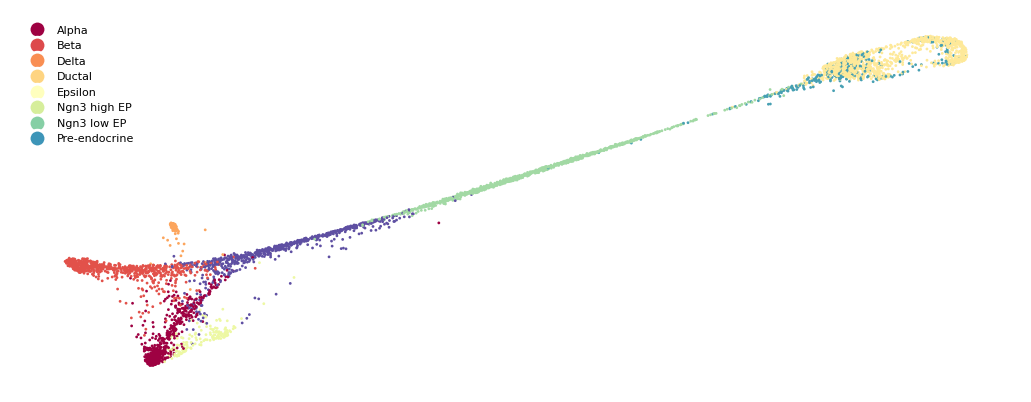

In [7]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='clusters', static=True, marker_size=1)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa2', embedded velocity vectors (adata.obsm)


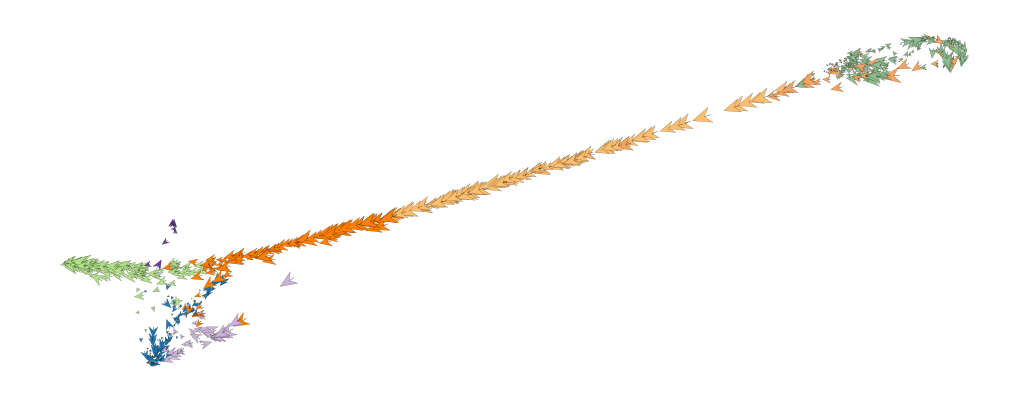

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
scv.pl.velocity_embedding(adata, basis='fa2', arrow_length=5, arrow_size=10, alpha=0, color_map='jet', 
                          title='', dpi=200, density=0.2, 
                          linewidth=0.05, show=False, ax=ax)
ax.set_aspect('equal')

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


(<Figure size 1280x960 with 2 Axes>, <AxesSubplot:>)

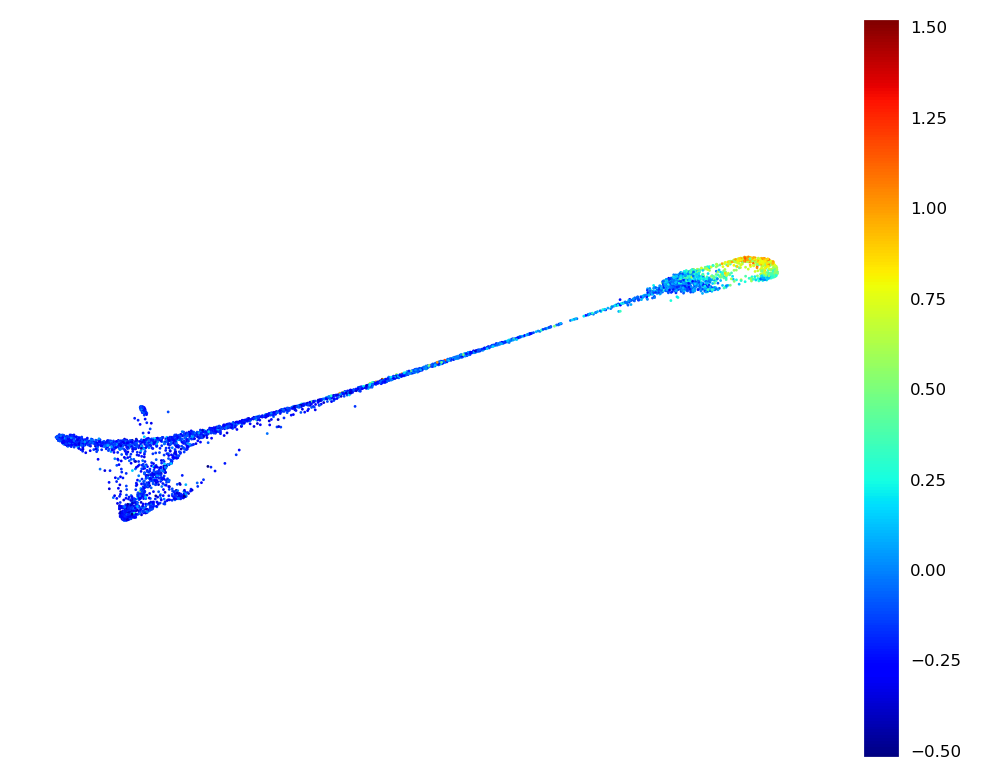

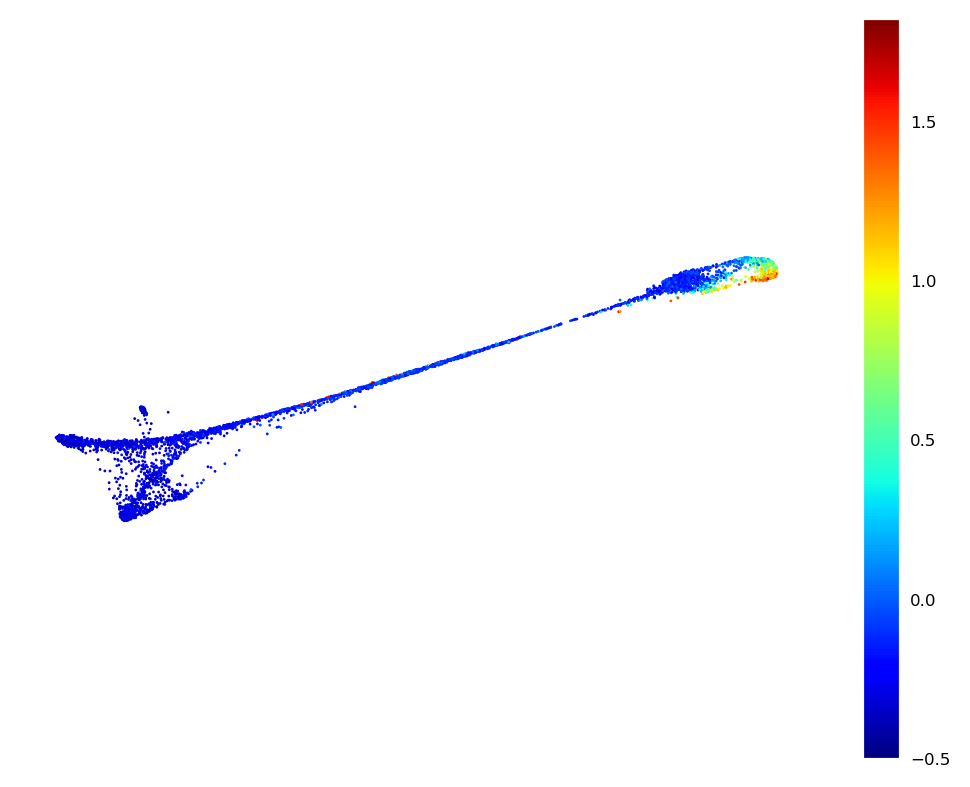

In [9]:
scv.tl.score_genes_cell_cycle(adata)
oci.pl.scatter(adata, x_key='X_fa2', color_key='S_score', cmap='jet', marker_size=1)
oci.pl.scatter(adata, x_key='X_fa2', color_key='G2M_score', cmap='jet', marker_size=1)

(<Figure size 1280x960 with 21 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>],
        [<AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'9'}>],
        [<AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'11'}>,
         <AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'14'}>],
        [<AxesSubplot:title={'center':'15'}>,
         <AxesSubplot:title={'center':'16'}>,
         <AxesSubplot:title={'center':'17'}>,
         <AxesSubplot:title={'center':'18'}>,
         <AxesSubplot:title={'center':'19'}>]], dtype=object))

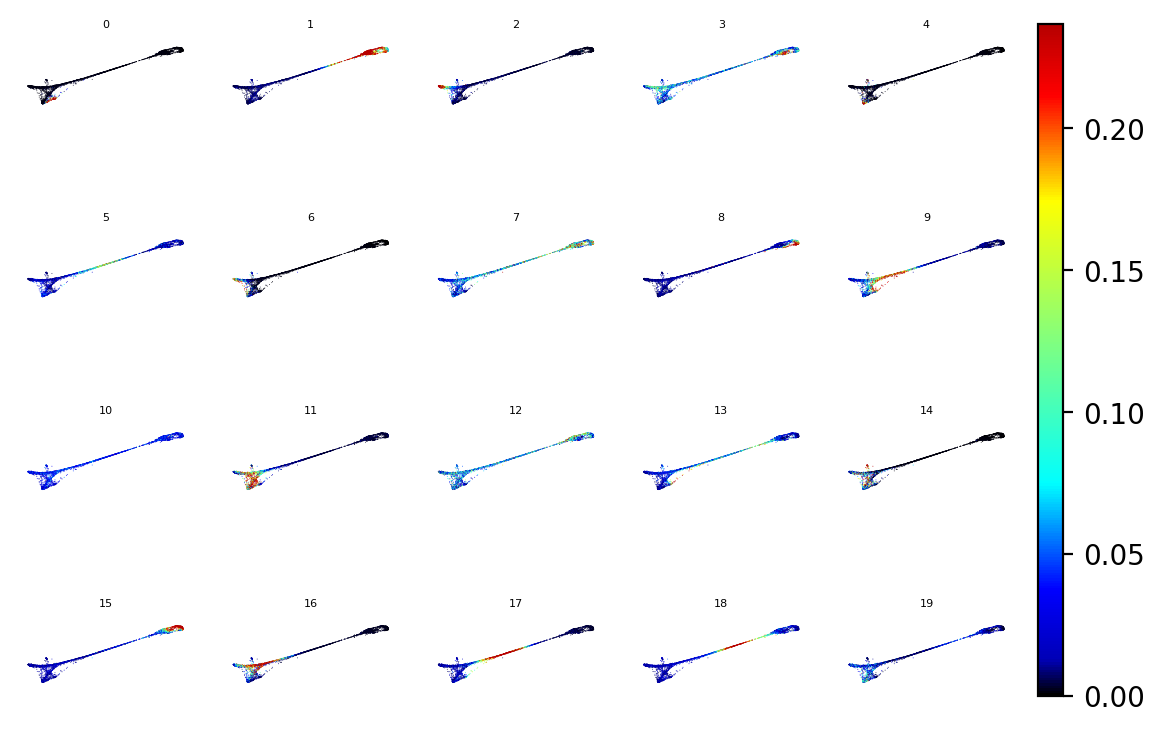

In [10]:
oci.pl.topics(adata, x_key='X_fa2', marker_size=0.1)